In [25]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [26]:
# -----------------------------
# 2. Enhanced PointNet2D
# -----------------------------
class PointNet2D(nn.Module):
    def __init__(self, input_dim=2, emb_dim=256):
        super(PointNet2D, self).__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, emb_dim, kernel_size=1),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU()
        )

    def forward(self, x, mask=None):
        # x: (B, N, 2) -> (B, 2, N)
        x = x.transpose(1, 2)
        features = self.mlp(x)  # (B, emb_dim, N)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, N)
            features = features.masked_fill(mask == 0, -1e2)

        embedding = torch.max(features, dim=2)[0]  # (B, emb_dim)
        return embedding


In [27]:
# -----------------------------
# 3. LSTM Slice Encoder
# -----------------------------
class LSTMSliceEncoder(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=256, num_layers=4, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

    def forward(self, x):
        # x: (B, S, D)
        _, (h_n, _) = self.lstm(x)
        if self.lstm.bidirectional:
            return torch.cat((h_n[-2], h_n[-1]), dim=-1)  # (B, 2H)
        else:
            return h_n[-1]  # (B, H)

In [28]:
# -----------------------------
# 4. Cd Regressor MLP
# -----------------------------
class CdRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [29]:
# -----------------------------
# 5. Full Model Assembly
# -----------------------------
class CdPredictorNet(nn.Module):
    def __init__(self, pointnet, lstm_encoder, regressor):
        super().__init__()
        self.pointnet = pointnet
        self.lstm_encoder = lstm_encoder
        self.regressor = regressor

    def forward(self, slices, point_mask, slice_mask):
        B, S, N, D = slices.shape
        flat_slices = slices.view(B * S, N, D)
        flat_mask = point_mask.view(B * S, N)

        slice_embs = self.pointnet(flat_slices, flat_mask)  # (B*S, 256)
        slice_embs = slice_embs.view(B, S, -1)  # (B, 80, 256)

        car_emb = self.lstm_encoder(slice_embs)  # (B, 512 if bidirectional)
        return self.regressor(car_emb)

In [30]:
# -----------------------------
# 6. Dataset Loader
# -----------------------------
class CarSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, ids_txt, npz_dir, csv_path, max_cars=None):
        self.car_ids = [line.strip() for line in open(ids_txt)]
        if max_cars:
            self.car_ids = self.car_ids[:max_cars]
        self.npz_dir = npz_dir
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        car_id = self.car_ids[idx]
        data = np.load(os.path.join(self.npz_dir, f"{car_id}_axis-x.npz"))
        slices = torch.tensor(data["slices"], dtype=torch.float32)  # (80, 6500, 2)
        point_mask = torch.tensor(data["point_mask"], dtype=torch.float32)  # (80, 6500)
        slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32)  # (80,)
        cd_value = self.df[self.df["Design"] == car_id]["Average Cd"].values[0]
        return slices, point_mask, slice_mask, torch.tensor(cd_value, dtype=torch.float32)

In [31]:
import os
import glob
import torch
import torch.nn as nn
from tqdm import tqdm

def train_model(resume=True, num_epochs=50, max_cars=2000,
                checkpoint_dir="../outputs/checkpoints", early_stopping_patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model components
    pointnet = PointNet2D()
    lstm_encoder = LSTMSliceEncoder()
    regressor = CdRegressor(input_dim=512)
    model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.SmoothL1Loss()  # Replaced with more stable alternative to MSE

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    best_loss = float("inf")
    patience_counter = 0
    epoch_losses = []

    # Resume from checkpoint if exists
    if resume:
        checkpoints = sorted(glob.glob(f"{checkpoint_dir}/epoch_*_loss*.pt"))
        if checkpoints:
            latest_ckpt = checkpoints[-1]
            print(f"🔄 Resuming from checkpoint: {latest_ckpt}")
            state = torch.load(latest_ckpt, map_location=device)
            model.load_state_dict(state['model'])
            optimizer.load_state_dict(state['optimizer'])
            start_epoch = state['epoch'] + 1
            epoch_losses = state.get('epoch_losses', [])
            best_loss = min(epoch_losses) if epoch_losses else float("inf")
        else:
            print("⏩ No previous checkpoint found, starting fresh.")

    # Load dataset
    dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/train_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=max_cars
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True , pin_memory=True)

    try:
        for epoch in range(start_epoch, num_epochs + 1):
            model.train()
            total_loss = 0.0
            pbar = tqdm(dataloader, desc=f"Epoch {epoch}", unit="batch")

            for slices, point_mask, slice_mask, cd_gt in pbar:
                slices = slices.to(device)
                point_mask = point_mask.to(device)
                cd_gt = cd_gt.to(device)

                pred = model(slices, point_mask, slice_mask)
                loss = loss_fn(pred, cd_gt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = loss.item() * slices.size(0)
                total_loss += batch_loss
                pbar.set_postfix(loss=batch_loss / slices.size(0))

            avg_loss = total_loss / len(dataloader.dataset)
            epoch_losses.append(avg_loss)
            print(f"✅ Epoch {epoch}: Avg SmoothL1 Loss = {avg_loss:.7f}")

            # Save checkpoint
            ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}_loss_{avg_loss:.4f}.pt")
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch_losses': epoch_losses
            }, ckpt_path)
            print(f"💾 Checkpoint saved: {ckpt_path}")

            # Early stopping
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"🛑 Early stopping triggered at epoch {epoch}.")
                    break

    except KeyboardInterrupt:
        print("\n⛔ Interrupted by user. Saving last checkpoint...")
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch_losses': epoch_losses
        }, os.path.join(checkpoint_dir, f"interrupted_epoch_{epoch}.pt"))
        print("🧷 Last checkpoint saved. Safe to resume later.")

    return model, epoch_losses


In [ ]:
import os
import glob
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_all_checkpoints(model=None, checkpoint_dir="../outputs/checkpoints", output_dir="../outputs/analysis", load_best=True):
    os.makedirs(output_dir, exist_ok=True)
    
    checkpoint_paths = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")))
    all_epoch_losses = []
    epoch_numbers = []
    best_ckpt_path = None
    best_loss = float("inf")

    print("\n📋 Epoch-wise Loss Summary:")
    for ckpt_path in checkpoint_paths:
        try:
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            losses = checkpoint.get("epoch_losses", [])
            epoch = checkpoint.get("epoch", None)

            if epoch is not None and losses:
                epoch_numbers.append(epoch)
                last_loss = losses[-1]
                all_epoch_losses.append(last_loss)

                if last_loss < best_loss:
                    best_loss = last_loss
                    best_ckpt_path = ckpt_path

                print(f"Epoch {epoch:02d} → Loss: {last_loss:.7f}")

        except Exception as e:
            print(f"⚠️ Skipped {ckpt_path}: {e}")
    
    # Save loss log
    loss_log_path = os.path.join(output_dir, "compiled_epoch_losses.json")
    with open(loss_log_path, "w") as f:
        json.dump({
            "epoch_numbers": epoch_numbers,
            "epoch_losses": all_epoch_losses
        }, f)
    print(f"\n📄 Saved compiled loss log to: {loss_log_path}")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=epoch_numbers, y=all_epoch_losses, marker="o")
    plt.title("📉 Training Loss Curve from Checkpoints")
    plt.xlabel("Epoch")
    plt.ylabel("SmoothL1 Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_curve_from_ckpts.png"))
    plt.show()

    # Plot deltas
    loss_deltas = [all_epoch_losses[i] - all_epoch_losses[i-1] for i in range(1, len(all_epoch_losses))]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=epoch_numbers[1:], y=loss_deltas)
    plt.title("📊 Δ Loss Between Checkpoints")
    plt.xlabel("Epoch")
    plt.ylabel("Δ Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_deltas_from_ckpts.png"))
    plt.show()

    print(f"✅ Done analyzing {len(epoch_numbers)} checkpoints")

    # Optional: Load best checkpoint into existing model
    if load_best and best_ckpt_path and model is not None:
        s
        print(f"\n🏆 Loading best checkpoint: {best_ckpt_path} (loss = {best_loss:.7f})")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(best_ckpt_path, map_location=device)
        model.load_state_dict(checkpoint['model'])
        model.eval()
        print("📦 Model updated with best checkpoint and set to eval mode.")

    return model

In [33]:
# Start training
model, loss_log = train_model(
    resume=True,
    num_epochs=70,
    max_cars=5000,
    checkpoint_dir="../outputs/checkpoints",
    early_stopping_patience=5
)

🔄 Resuming from checkpoint: ../outputs/checkpoints\epoch_59_loss_0.0001.pt


Epoch 60:   1%|          | 30/2500 [00:08<11:31,  3.57batch/s, loss=8.22e-5] 


⛔ Interrupted by user. Saving last checkpoint...
🧷 Last checkpoint saved. Safe to resume later.



📋 Epoch-wise Loss Summary:
Epoch 01 → Loss: 0.0006879
Epoch 02 → Loss: 0.0002314
Epoch 03 → Loss: 0.0002070
Epoch 04 → Loss: 0.0001874
Epoch 05 → Loss: 0.0001652
Epoch 06 → Loss: 0.0001606
Epoch 07 → Loss: 0.0001380
Epoch 08 → Loss: 0.0001385
Epoch 09 → Loss: 0.0001377
Epoch 10 → Loss: 0.0001323
Epoch 11 → Loss: 0.0001273
Epoch 12 → Loss: 0.0001197
Epoch 13 → Loss: 0.0001127
Epoch 14 → Loss: 0.0001229
Epoch 15 → Loss: 0.0001115
Epoch 16 → Loss: 0.0001087
Epoch 17 → Loss: 0.0001046
Epoch 18 → Loss: 0.0001022
Epoch 19 → Loss: 0.0001093
Epoch 20 → Loss: 0.0001037
Epoch 21 → Loss: 0.0001144
Epoch 22 → Loss: 0.0001001
Epoch 23 → Loss: 0.0000978
Epoch 24 → Loss: 0.0001008
Epoch 25 → Loss: 0.0000956
Epoch 26 → Loss: 0.0000913
Epoch 27 → Loss: 0.0000971
Epoch 28 → Loss: 0.0000893
Epoch 29 → Loss: 0.0000904
Epoch 30 → Loss: 0.0000893
Epoch 31 → Loss: 0.0000825
Epoch 32 → Loss: 0.0000849
Epoch 33 → Loss: 0.0000842
Epoch 34 → Loss: 0.0000833
Epoch 35 → Loss: 0.0000810
Epoch 36 → Loss: 0.0000851


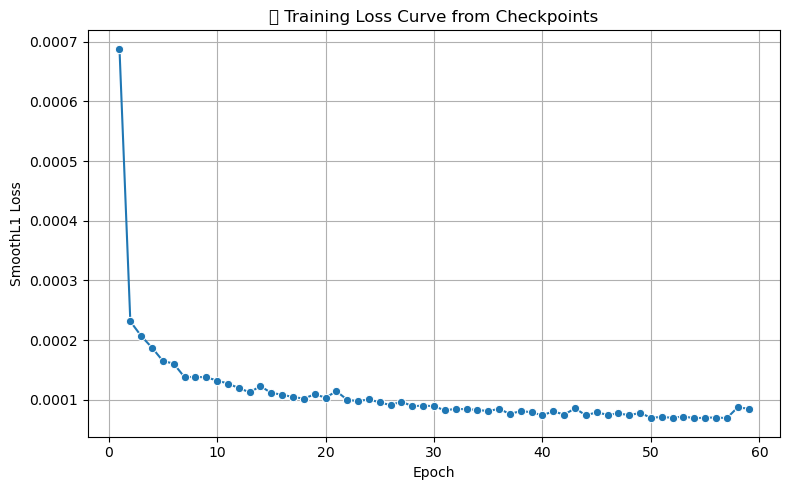

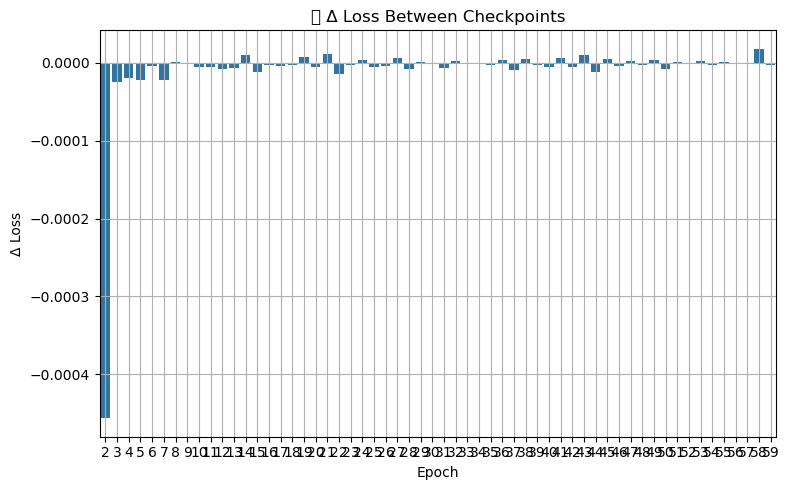

✅ Done analyzing 59 checkpoints

🏆 Loading best checkpoint: ../outputs/checkpoints\epoch_54_loss_0.0001.pt (loss = 0.0000692)
📦 Model updated with best checkpoint and set to eval mode.


In [ ]:
warnings.filterwarnings("ignore")
# Analyze checkpoints and update model with best weights
model = analyze_all_checkpoints(model=model)

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Load full car IDs from training split
with open("../data/subset_dir/train_design_ids.txt") as f:
    all_ids = [line.strip() for line in f]

# Select 100 unseen IDs after first 1000 used in training
test_ids = all_ids[5000:5100]

# Load CSV for ground truth Cd values
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

preds = []
trues = []

for car_id in test_ids:
    path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    data = np.load(path)

    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        cd_pred = model(slices, point_mask, slice_mask).item()

    cd_true = df[df["Design"] == car_id]["Average Cd"].values[0]

    preds.append(cd_pred)
    trues.append(cd_true)

    print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.4f} | True Cd: {cd_true:.4f}")

# Compute and print R²
r2 = r2_score(trues, preds)
print(f"\n📊 R² Score on unseen 100-car subset: {r2:.4f}")


🚗 DrivAer_F_D_WM_WW_3697 → Predicted Cd: 0.3056 | True Cd: 0.3203
🚗 DrivAer_F_D_WM_WW_1540 → Predicted Cd: 0.2804 | True Cd: 0.2775
🚗 DrivAer_F_D_WM_WW_3894 → Predicted Cd: 0.2878 | True Cd: 0.3005
🚗 DrivAer_F_D_WM_WW_1310 → Predicted Cd: 0.2802 | True Cd: 0.2976
🚗 DrivAer_F_D_WM_WW_3822 → Predicted Cd: 0.2811 | True Cd: 0.2898
🚗 DrivAer_F_D_WM_WW_2872 → Predicted Cd: 0.3018 | True Cd: 0.3109
🚗 DrivAer_F_D_WM_WW_1616 → Predicted Cd: 0.2996 | True Cd: 0.3060
🚗 DrivAer_F_D_WM_WW_0163 → Predicted Cd: 0.2807 | True Cd: 0.2822
🚗 DrivAer_F_D_WM_WW_1719 → Predicted Cd: 0.3165 | True Cd: 0.3341
🚗 DrivAer_F_D_WM_WW_0964 → Predicted Cd: 0.2807 | True Cd: 0.2713
🚗 DrivAer_F_D_WM_WW_3265 → Predicted Cd: 0.3179 | True Cd: 0.3349
🚗 DrivAer_F_D_WM_WW_2894 → Predicted Cd: 0.3151 | True Cd: 0.3281
🚗 DrivAer_F_D_WM_WW_3882 → Predicted Cd: 0.2825 | True Cd: 0.2852
🚗 DrivAer_F_D_WM_WW_0885 → Predicted Cd: 0.3142 | True Cd: 0.3253
🚗 DrivAer_F_D_WM_WW_1937 → Predicted Cd: 0.2848 | True Cd: 0.2820
🚗 DrivAer_

In [ ]:
# -----------------------------
# 🔍 Robust Evaluation Script for complete Validation/Test Sets
# -----------------------------
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# CHANGE THIS to 'val_design_ids.txt' or 'test_design_ids.txt'
id_file = "../data/subset_dir/val_design_ids.txt"

# Load car IDs from val/test set
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd CSV
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Storage
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        cd_pred = model(slices, point_mask, slice_mask).item()

    cd_true = df[df["Design"] == car_id]["Average Cd"].values[0]

    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final Metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
os.makedirs("../outputs/eval", exist_ok=True)
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")


🚗 E_S_WW_WM_107 → Predicted Cd: 0.281352 | True Cd: 0.291263
🚗 F_S_WWS_WM_219 → Predicted Cd: 0.264895 | True Cd: 0.282675
🚗 F_S_WWC_WM_402 → Predicted Cd: 0.237765 | True Cd: 0.255362
🚗 N_S_WW_WM_231 → Predicted Cd: 0.260460 | True Cd: 0.250860
🚗 N_S_WWS_WM_300 → Predicted Cd: 0.237992 | True Cd: 0.212679
🚗 E_S_WWC_WM_031 → Predicted Cd: 0.263024 | True Cd: 0.250199
🚗 N_S_WWS_WM_347 → Predicted Cd: 0.269716 | True Cd: 0.261281
🚗 E_S_WWC_WM_640 → Predicted Cd: 0.265781 | True Cd: 0.245123
🚗 N_S_WWS_WM_330 → Predicted Cd: 0.262450 | True Cd: 0.236111
🚗 E_S_WW_WM_203 → Predicted Cd: 0.284679 | True Cd: 0.292899
🚗 N_S_WWC_WM_191 → Predicted Cd: 0.238712 | True Cd: 0.244601
🚗 E_S_WWC_WM_641 → Predicted Cd: 0.282377 | True Cd: 0.274664
🚗 N_S_WWC_WM_087 → Predicted Cd: 0.262760 | True Cd: 0.249482
🚗 F_S_WWC_WM_666 → Predicted Cd: 0.263492 | True Cd: 0.276765
🚗 N_S_WWC_WM_219 → Predicted Cd: 0.268809 | True Cd: 0.290724
🚗 F_S_WWS_WM_248 → Predicted Cd: 0.237494 | True Cd: 0.249032
🚗 F_S_WWC_W